<a href="https://colab.research.google.com/github/EmanoneL/data_analysis_pet_project/blob/main/SovkomTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание на собеседование


**Предыстория**: Каршеринговая компания с крупным автопарком машин в нескольких городах совершает тысячи поездок ежедневно, и пользователи очень довольны сервисом. Чтобы поддерживать эту положительную динамику, необходимо своевременное обслуживание машин, чтобы избежать длительных простоев и снижения доступности для аренды.

**Проблема**:  С крупным автопарком и активными пользователями, машины в каршеринговой компании подвержены значительному износу и возможным поломкам из-за агрессивного использования. Несмотря на это, техническая бригада не успевает ежедневно обслуживать все автомобили, что затрудняет предотвращение поломок


**Задача**: Необходимо сформировать список обхода машин. Тогда, тех. бригаде не пришлось бы объезжать все машины, а было бы достаточно обойти только те машины, которые вероятнее всего выйдут из строя раньше. Чтобы определить такой список, надо уметь прогнозировать вид поломки машин.

**Описание данных**:
sample_id — идентификатор записи

car_id — идентификатор машины

model — марка авто

car_type — класс авто

fuel_type — тип топлива машины

car_rating — общий рейтинг к концу 2021го года

riders — общее число поездок к концу 2021го года

year_to_start — год выпуска машины

year_to_work — год начала работы в автопарке

date_to_break — дата поломки

target_class — класс поломки, 9 видов

## 1. Чтение и запись файлов с помощью pandas

### Импорт библиотек

In [ ]:
!pip install catboost==1.2

In [106]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### a. Прочитать файл “features.xlsx” в переменную pd.DataFrame features.

In [ ]:
features = pd.read_excel('features.xlsx')

### b. Вывести (напечатать) первые пять и последние пять строк таблицы features.

In [ ]:
display(features.head(5), features.tail(5))

,sample_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,date_to_break
0,559c6886,Skoda Rapid,economy,petrol,4.80,2013,42269,2019,NaT
1,4cd4a5f2,Renault Sandero,standart,petrol,4.32,2015,90014,2016,2022-02-04
2,77dd0842,Smart ForTwo,economy,petrol,4.46,2015,82684,2017,2022-02-09
3,03671dd2,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,2022-04-20
4,3cb03b4a,Smart ForFour,economy,petrol,2.80,2014,68833,2021,2022-02-12


,sample_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,date_to_break
995,2ec0e3b5,VW Polo VI,economy,petrol,5.28,2014,62163,2016,2022-02-28
996,67d10faf,Kia Rio X,economy,petrol,5.48,2014,61723,2020,2022-02-08
997,3aa93437,Kia Rio X,economy,petrol,4.96,2015,71765,2019,2022-02-02
998,defb84d6,Renault Kaptur,standart,petrol,4.36,2011,611,2016,2022-02-06
999,f5f077b6,Smart ForFour,economy,NaN,4.88,2015,81745,2015,2022-03-26


### c.	Вывести (напечатать) размеры таблицы features - число строк и число столбцов.

In [ ]:
features.shape

(1000, 9)

### d.	Прочитать файл “labels.xlsx” в переменную pd.DataFrame labels.Важно! В файле несколько листов. Необходимо прочитать их все

In [ ]:
row_labels = pd.read_excel('labels.xlsx', sheet_name=None)
labels = pd.concat(row_labels.values(), ignore_index=True)

### e. Вывести (напечатать) первые пять и последние пять строк таблицы labels.

In [ ]:
display(labels.head(5), labels.tail(5))

,sample_id,target_class
0,62b0b6aa,engine_ignition
1,3f7cfeaa,electro_bug
2,e24a3d20,break_bug
3,7f23a69e,wheel_shake
4,8999f17f,engine_check


,sample_id,target_class
5908,9fcea555,wheel_shake
5909,670f33ba,break_bug
5910,0d1170b4,another_bug
5911,59a12af4,break_bug
5912,0593548c,another_bug


### f.	Вывести (напечатать) размеры таблицы labels - число строк и число столбцов.


In [ ]:
labels.shape

(5913, 2)

### g.	Объединить таблицы features и labels в один pd.DataFrame dataset. Объединение производить по столбцу sample_id использовать только ключи таблицы features.



Проверим, не повторяются ли значения в датасетах

In [ ]:
len(features['sample_id'].unique())

1000

In [ ]:
len(labels['sample_id'].unique())

5913

Не повторяются, можем проводить объединение

In [ ]:
dataset = pd.merge(features, labels, on='sample_id', how='left')

###h.	Вывести (напечатать) первые пять и последние пять строк таблицы dataset.

In [ ]:
display(dataset.head(5), dataset.tail(5))

,sample_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,date_to_break,target_class
0,559c6886,Skoda Rapid,economy,petrol,4.80,2013,42269,2019,NaT,engine_overheat
1,4cd4a5f2,Renault Sandero,standart,petrol,4.32,2015,90014,2016,2022-02-04,electro_bug
2,77dd0842,Smart ForTwo,economy,petrol,4.46,2015,82684,2017,2022-02-09,break_bug
3,03671dd2,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,2022-04-20,another_bug
4,3cb03b4a,Smart ForFour,economy,petrol,2.80,2014,68833,2021,2022-02-12,gear_stick


,sample_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,date_to_break,target_class
995,2ec0e3b5,VW Polo VI,economy,petrol,5.28,2014,62163,2016,2022-02-28,engine_ignition
996,67d10faf,Kia Rio X,economy,petrol,5.48,2014,61723,2020,2022-02-08,engine_fuel
997,3aa93437,Kia Rio X,economy,petrol,4.96,2015,71765,2019,2022-02-02,electro_bug
998,defb84d6,Renault Kaptur,standart,petrol,4.36,2011,611,2016,2022-02-06,engine_fuel
999,f5f077b6,Smart ForFour,economy,NaN,4.88,2015,81745,2015,2022-03-26,another_bug


## Работа с анализом данных

### a.	Вывести тип данных каждого столбца. Преобразовать из типа object в нужные форматы числовые и форматы дат (если это необходимо).

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sample_id      1000 non-null   object        
 1   model          1000 non-null   object        
 2   car_type       1000 non-null   object        
 3   fuel_type      999 non-null    object        
 4   car_rating     1000 non-null   float64       
 5   year_to_start  1000 non-null   int64         
 6   riders         1000 non-null   int64         
 7   year_to_work   1000 non-null   int64         
 8   date_to_break  998 non-null    datetime64[ns]
 9   target_class   1000 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 78.3+ KB


### b.	Вывести (напечатать) число пропущенных и нулевых значений по каждому столбцу.

In [ ]:
dataset[dataset.isnull().any(axis=1) | (dataset == 0).any(axis=1)]

,sample_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,date_to_break,target_class
0,559c6886,Skoda Rapid,economy,petrol,4.80,2013,42269,2019,NaT,engine_overheat
978,046a9d07,Volkswagen ID.4,premium,electro,3.02,2013,41778,2020,NaT,electro_bug
992,8f085129,Skoda Rapid,economy,petrol,0.00,2014,59787,2015,2022-04-07,another_bug
999,f5f077b6,Smart ForFour,economy,NaN,4.88,2015,81745,2015,2022-03-26,another_bug


In [ ]:
def count_nans_in_features(dataset):
  missing_values = dataset.isna().sum()
  zero_values = (dataset == 0).sum()

  result = pd.DataFrame({
      'Пропуски (NaN или NaT)': missing_values,
      'Нули (0)': zero_values
  })
  return result
count_nans_in_features(dataset)

,Пропуски (NaN или NaT),Нули (0)
sample_id,0,0
model,0,0
car_type,0,0
fuel_type,1,0
car_rating,0,1
year_to_start,0,0
riders,0,0
year_to_work,0,0
date_to_break,2,0
target_class,0,0


### c.	Какая модель авто сломалась раньше остальных?

In [ ]:
dataset.sort_values('date_to_break').iloc[0]['model']

'Kia Rio X'

### d.	Авто какого года выпуска присутствуют в выборке? Вывести все уникальные года выпуска.

In [ ]:
dataset['year_to_start'].unique()

array([2013, 2015, 2014, 2012, 2011, 2017, 2016])

### e.	В какой год начало работать наибольшее количество авто и сколько авто начало работать?

<Axes: >

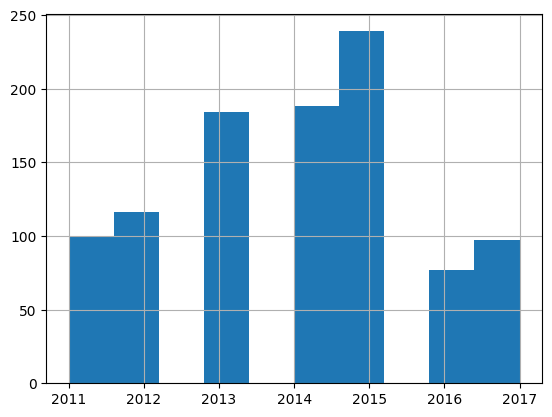

In [ ]:
dataset['year_to_start'].hist()

In [ ]:
dataset['year_to_start'].value_counts().nlargest(1)

,count
year_to_start,
2015,239


### f.	Сколько всего авто совершило меньше чем 10000 поездок?

In [ ]:
dataset[dataset['riders'] < 10000].shape[0]

93

### g.	Какой класс авто, у которых рейтинг выше медианного значения является вторым по популярности в выборке?

In [ ]:
dataset[dataset['car_rating'] > dataset['car_rating'].median()]['car_type'].value_counts().nlargest(2).iloc[[1]]

,count
car_type,
standart,134


### h.	Сколько поездок на авто премиум класса 2016 года выпуска с электрическим двигателем было совершено?

In [ ]:
dataset[(dataset['car_type'] == 'premium') &
        (dataset['year_to_start'] == 2016) &
        (dataset['fuel_type'] == 'electro')]['riders'].sum()

476627

## Машинное обучение

### a.	Заполнить пропущенные значения в dataset

In [ ]:
count_nans_in_features(dataset)

,Пропуски (NaN или NaT),Нули (0)
sample_id,0,0
model,0,0
car_type,0,0
fuel_type,1,0
car_rating,0,1
year_to_start,0,0
riders,0,0
year_to_work,0,0
date_to_break,2,0
target_class,0,0


Посмотрим распределение фичей, в которых есть пропуски и нули

<Axes: >

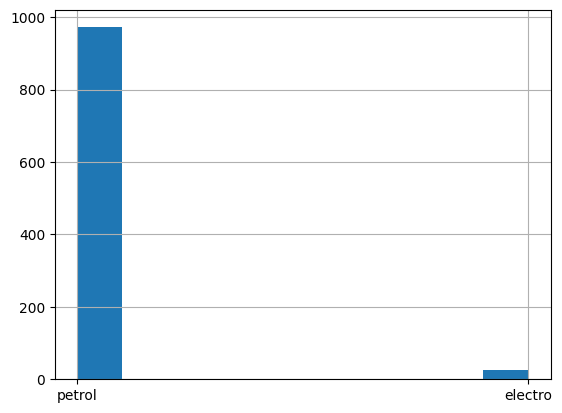

In [ ]:
dataset['fuel_type'].hist()

<Axes: >

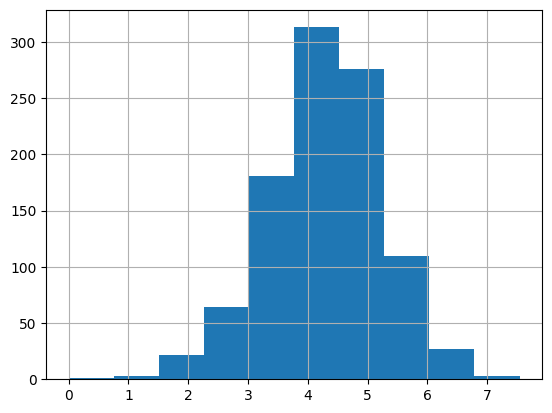

In [ ]:
dataset['car_rating'].hist()

<Axes: >

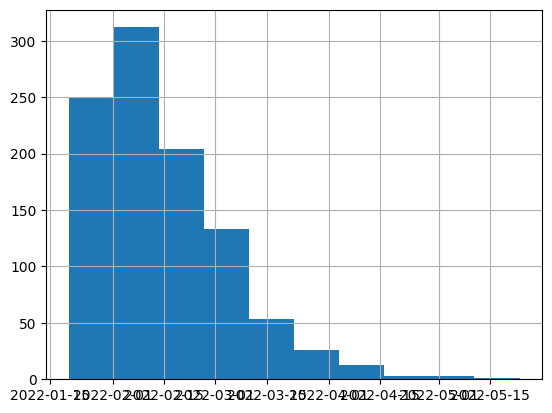

In [ ]:
dataset['date_to_break'].hist()

Заменим недостающие данные

In [ ]:
dataset['fuel_type'] = dataset.groupby('model')['fuel_type'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) # категориальныя переменная
)

dataset['car_rating'] = dataset.groupby('model')['car_rating'].transform(
    lambda x: x.replace(0, x.mean()) # числовая переменная
)

# Обработка date_to_break: заполняем NaN наиболее частой датой
dataset['date_to_break'] = dataset.groupby('model')['date_to_break'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) # дата
)


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sample_id      1000 non-null   object        
 1   model          1000 non-null   object        
 2   car_type       1000 non-null   object        
 3   fuel_type      1000 non-null   object        
 4   car_rating     1000 non-null   float64       
 5   year_to_start  1000 non-null   int64         
 6   riders         1000 non-null   int64         
 7   year_to_work   1000 non-null   int64         
 8   date_to_break  1000 non-null   datetime64[ns]
 9   target_class   1000 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 78.3+ KB


### b.	Разделить выборку на тестовую и тренировочную

In [ ]:
dataset['target_class'].value_counts()

,count
target_class,
another_bug,121
engine_ignition,119
engine_overheat,116
electro_bug,113
break_bug,113
gear_stick,113
engine_fuel,112
engine_check,112
wheel_shake,81


In [ ]:
y = dataset['target_class']
X = dataset.drop(columns=['target_class','sample_id'])

Задача многоклассовой классификации. Чтобы грамотно разбить такую выборку, важно, чтобы в тестовую выборку значения классов попали соразмерно их распределению в исходных данных

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### c.	На основе dataset решить задачу классификации

Признаки:
sample_id
car_id
model
car_type
fuel_type
car_rating
riders
year_to_start
year_to_work
date_to_break

Целевая переменная:
target_class


In [ ]:
X_train.head(1)

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,date_to_break
752,Mini Cooper,business,petrol,3.82,2015,80980,2021,2022-02-16


Для обучения данной модели требуется применить все имеющиеся признаки. Признак car_id отсутствует в исходных данных, возможно, опечатка

Признак sample_id является иднтификатором и у нас нет информации о смысле, который он может содержать. Полезно было бы извлечь из него информацию, но пока принято решение его удалить

Для решения задачи многоклассовой классификации применим модель CatBoostClassifier. Данная модель не требует one-hot преобразования для переменных и масштабирования данных перед применением

In [ ]:
cat_features = ['model', 'car_type', 'fuel_type']

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 752 to 97
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   model          800 non-null    object        
 1   car_type       800 non-null    object        
 2   fuel_type      800 non-null    object        
 3   car_rating     800 non-null    float64       
 4   year_to_start  800 non-null    int64         
 5   riders         800 non-null    int64         
 6   year_to_work   800 non-null    int64         
 7   date_to_break  800 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 56.2+ KB


In [133]:
model = CatBoostClassifier(cat_features=cat_features, loss_function='MultiClass', verbose=True)
model.fit(X_train, y_train)

Learning rate set to 0.078231
0:	learn: 2.1468709	total: 90.5ms	remaining: 1m 30s
1:	learn: 2.1036461	total: 183ms	remaining: 1m 31s
2:	learn: 2.0553161	total: 267ms	remaining: 1m 28s
3:	learn: 2.0209743	total: 359ms	remaining: 1m 29s
4:	learn: 1.9908027	total: 415ms	remaining: 1m 22s
5:	learn: 1.9552343	total: 499ms	remaining: 1m 22s
6:	learn: 1.9226852	total: 576ms	remaining: 1m 21s
7:	learn: 1.8970598	total: 603ms	remaining: 1m 14s
8:	learn: 1.8661467	total: 713ms	remaining: 1m 18s
9:	learn: 1.8427083	total: 772ms	remaining: 1m 16s
10:	learn: 1.8261613	total: 875ms	remaining: 1m 18s
11:	learn: 1.8067603	total: 1.05s	remaining: 1m 26s
12:	learn: 1.7906182	total: 1.21s	remaining: 1m 31s
13:	learn: 1.7702877	total: 1.27s	remaining: 1m 29s
14:	learn: 1.7568580	total: 1.29s	remaining: 1m 24s
15:	learn: 1.7412702	total: 1.36s	remaining: 1m 23s
16:	learn: 1.7305916	total: 1.44s	remaining: 1m 23s
17:	learn: 1.7163943	total: 1.49s	remaining: 1m 21s
18:	learn: 1.7111025	total: 1.5s	remaining:

In [134]:
y_pred_test = model.predict(X_test)

### d.	Вывести (напечатать) оценку работы метода

Проведем оценку качества, используя метрики для задачи классификации. Будем считать по макроусреднению

In [138]:
accuracy = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test, average='macro')
precision = precision_score(y_test, y_pred_test, average='macro')
recall = recall_score(y_test, y_pred_test, average='macro')

# Выводим результаты
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.305
F1 Score: 0.2913221395283643
Precision: 0.30252017189946256
Recall: 0.2950977162933685


### e.	Нарисовать графики сравнения факта и прогноза

Построим confusion matrix для сравнения

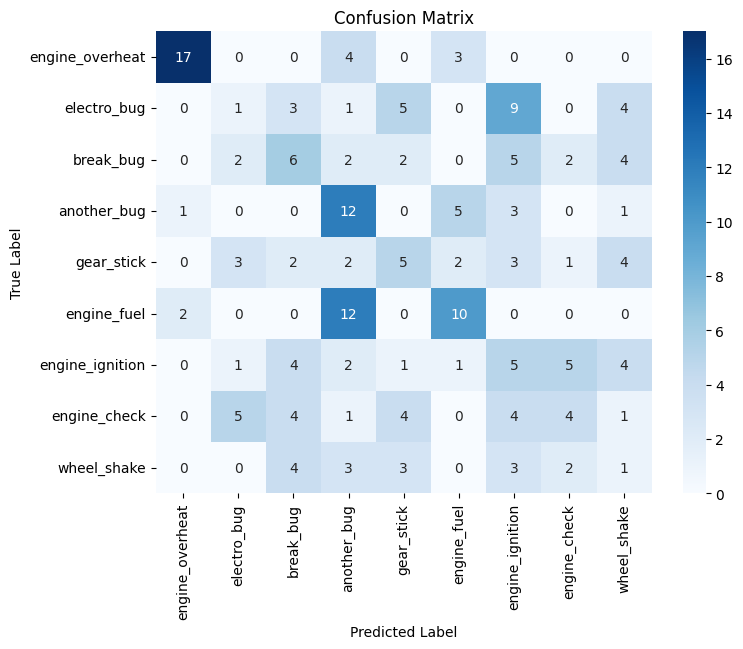

In [137]:
cm = confusion_matrix(y_test, y_pred_test)

# Визуализируем матрицу ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset['target_class'].unique(),
            yticklabels=dataset['target_class'].unique())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

На текущем этапе можно сказать, что модель не очень хорошо предсказывает классы в тестовой выборке и довольно часто ошибается. Чтобы улучшить результат, может потребоваться больше данных в тестовой выборке либо дополнительная обработка данных и выделение новых признаков